In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import pandas as pd
import numpy as np

# Example 1 - When not use it
* small datasets -> not enough samples in some leaves (uncomment `TRYIT#1`)
* the base estimator is already good enough (there is not much to improve for the recalibration procedure)

In [4]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(
    data.data, data.target, test_size=0.3, random_state=23)

In [5]:
from seasalt import CalibrateOnLeaves
from sklearn.tree import DecisionTreeClassifier

# Only 1 sample per leaf is the default
m1 = DecisionTreeClassifier()
m2 = CalibrateOnLeaves(model=DecisionTreeClassifier())
# TRYIT#1
#m1 = DecisionTreeClassifier(min_samples_leaf=30)
#m2 = CalibrateOnLeaves(model=DecisionTreeClassifier(min_samples_leaf=30))

m1.fit(X_train, Y_train)
m2.fit(X_train, Y_train)

y1 = m1.predict_proba(X_valid)
y2 = m2.predict_proba(X_valid)

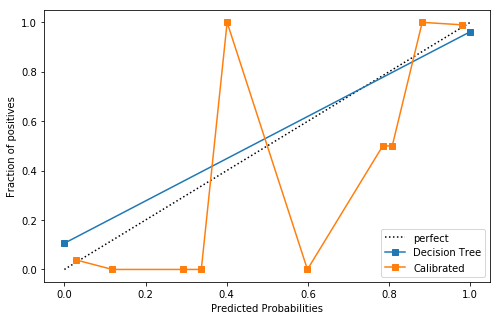

In [6]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,5));
ax.plot([0, 1], [0, 1], "k:", label="perfect");

fraction_of_positives, mean_predicted_value = calibration_curve(Y_valid, y1[:,1], n_bins=20)
ax.plot(mean_predicted_value, fraction_of_positives, "s-", label='Decision Tree');

fraction_of_positives, mean_predicted_value = calibration_curve(Y_valid, y2[:,1], n_bins=20)
ax.plot(mean_predicted_value, fraction_of_positives, "s-", label='Calibrated');

ax.legend(loc="lower right");
ax.set_ylabel("Fraction of positives");
ax.set_xlabel("Predicted Probabilities");

# Example 2 - more datapoints
* Dataset: [on kaggle](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009) or [UCI](https://archive.ics.uci.edu/ml/datasets/wine+quality)

In [7]:
!curl https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv --output ~/tmp/winequality-red.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 84199  100 84199    0     0  27012      0  0:00:03  0:00:03 --:--:-- 27021


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


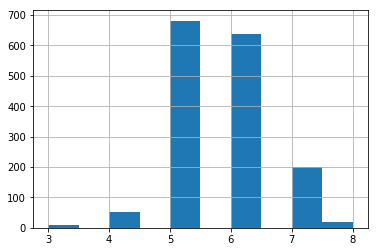

In [8]:
df = pd.read_csv('~/tmp/winequality-red.csv', sep=";")
df['quality'].hist();
df.head()

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(
    df.copy().drop(['quality'], axis=1).values, 
    df.copy()[['quality']].values.ravel() >= 6, 
    test_size=0.3, random_state=23)

## Decision Tree

In [10]:
from seasalt import CalibrateOnLeaves
from sklearn.tree import DecisionTreeClassifier

m1 = DecisionTreeClassifier()
m2 = CalibrateOnLeaves(model=DecisionTreeClassifier())

m1.fit(X_train, Y_train)
m2.fit(X_train, Y_train)

y1 = m1.predict_proba(X_valid)
y2 = m2.predict_proba(X_valid)

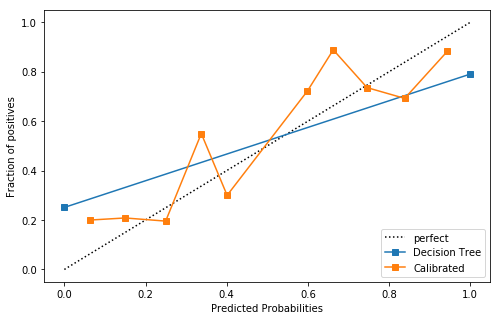

In [11]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,5));
ax.plot([0, 1], [0, 1], "k:", label="perfect");

fraction_of_positives, mean_predicted_value = calibration_curve(Y_valid, y1[:,1], n_bins=10)
ax.plot(mean_predicted_value, fraction_of_positives, "s-", label='Decision Tree');

fraction_of_positives, mean_predicted_value = calibration_curve(Y_valid, y2[:,1], n_bins=10)
ax.plot(mean_predicted_value, fraction_of_positives, "s-", label='Calibrated');

ax.legend(loc="lower right");
ax.set_ylabel("Fraction of positives");
ax.set_xlabel("Predicted Probabilities");

## ExtraTree

In [12]:
from seasalt import CalibrateOnLeaves
from sklearn.ensemble import ExtraTreesClassifier

m1 = ExtraTreesClassifier(n_estimators=10, min_samples_leaf=30)
m2 = CalibrateOnLeaves(model=ExtraTreesClassifier(n_estimators=10, min_samples_leaf=30))

m1.fit(X_train, Y_train)
m2.fit(X_train, Y_train)

y1 = m1.predict_proba(X_valid)
y2 = m2.predict_proba(X_valid)

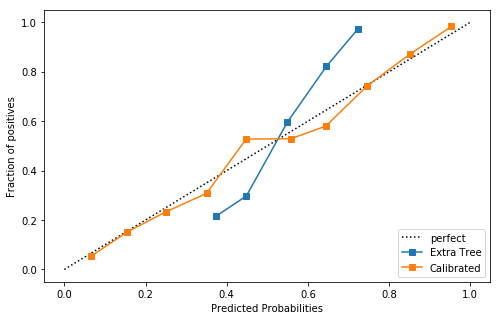

In [13]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,5));
ax.plot([0, 1], [0, 1], "k:", label="perfect");

fraction_of_positives, mean_predicted_value = calibration_curve(Y_valid, y1[:,1], n_bins=10)
ax.plot(mean_predicted_value, fraction_of_positives, "s-", label='Extra Tree');

fraction_of_positives, mean_predicted_value = calibration_curve(Y_valid, y2[:,1], n_bins=10)
ax.plot(mean_predicted_value, fraction_of_positives, "s-", label='Calibrated');

ax.legend(loc="lower right");
ax.set_ylabel("Fraction of positives");
ax.set_xlabel("Predicted Probabilities");

# Further Information
* https://gdmarmerola.github.io/probability-calibration/